# Cox-PH and DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).
We will use the METABRIC data sets as an example

A more detailed introduction to the `pycox` package can be found in [this notebook](https://nbviewer.jupyter.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb) about the `LogisticHazard` method.

The main benefit Cox-CC (and the other Cox methods) has over Logistic-Hazard is that it is a continuous-time method, meaning we do not need to discretize the time scale.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt
from pycox.datasets import gbsg
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

In [26]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## Dataset

We load the METABRIC data set and split in train, test and validation.

In [27]:
df_train = gbsg.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [28]:
df_train.shape

(1429, 9)

In [29]:
df_train.head()

x0   x1   x2    x3   x4     x5     x6   duration  event
1  0.0  1.0  0.0  27.0  1.0  717.0   95.0  84.000000      0
3  0.0  0.0  0.0  28.0  1.0  251.0   11.0  84.000000      0
5  0.0  1.0  0.0  32.0  1.0  665.0   94.0  84.000000      0
6  0.0  0.0  1.0  56.0  1.0  110.0  238.0  84.000000      0
7  0.0  1.0  1.0  50.0  1.0  302.0  100.0  79.802872      1

## Feature transforms
We have 9 covariates, in addition to the durations and event indicators.

We will standardize the 5 numerical covariates, and leave the binary variables as is. As variables needs to be of type `'float32'`, as this is required by pytorch.

In [30]:
cols_standardize = ['x3', 'x5', 'x6']
cols_leave = ['x0', 'x1', 'x2', 'x4']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [31]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

We need no label transforms

In [32]:
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

## Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout. 
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerSurvival(nn.Module):
    def __init__(self, in_features, d_model=32, out_features=1, 
                 nhead=4, num_layers=2, dropout=0.1, batch_norm=True, output_bias=False):
        super().__init__()
        
        # Input projection - 将输入特征投影到Transformer的维度
        self.input_proj = nn.Linear(in_features, d_model)
        
        # Positional encoding - 位置编码
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Batch norm
        self.bn = nn.BatchNorm1d(d_model) if batch_norm else nn.Identity()
        
        # 直接输出层 - 从Transformer维度映射到输出维度
        self.output_layer = nn.Linear(d_model, out_features, bias=output_bias)
        
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

    def forward(self, x):
        # Input processing
        x = self.input_proj(x)  # [batch_size, in_features] -> [batch_size, d_model]
        x = self.bn(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Transformer processing
        # 添加序列维度并加上位置编码
        x = x.unsqueeze(1)  # [batch_size, d_model] -> [batch_size, 1, d_model]
        x = x + self.pos_encoding
        
        # Transformer处理
        x = self.transformer(x)  # [batch_size, 1, d_model]
        
        # 移除序列维度并直接输出
        x = x.squeeze(1)  # [batch_size, 1, d_model] -> [batch_size, d_model]
        
        # 直接映射到输出
        return self.output_layer(x)


# 简洁的创建函数
def create_transformer_network(in_features, d_model=32, out_features=1, 
                              batch_norm=True, dropout=0.1, output_bias=False,
                              nhead=4, num_layers=2):
    """创建简化的Transformer生存网络（无中间输出层）"""
    return TransformerSurvival(
        in_features=in_features,
        d_model=d_model,
        out_features=out_features,
        nhead=nhead,
        num_layers=num_layers,
        dropout=dropout,
        batch_norm=batch_norm,
        output_bias=output_bias
    )
# 使用方式
in_features = x_train.shape[1]
d_model = 64  # 替换原来的num_nodes[0]
out_features = 1
batch_norm = True
dropout = 0.1
output_bias = False

net = create_transformer_network(
    in_features=in_features,
    d_model=d_model,
    out_features=out_features,
    nhead=2,  # 建议d_model能被nhead整除
    num_layers=1,
    dropout=dropout,
    batch_norm=batch_norm,
    output_bias=output_bias
)

## Training the model

To train the model we need to define an optimizer. You can choose any `torch.optim` optimizer, but here we instead use one from `tt.optim` as it has some added functionality.
We use the `Adam` optimizer, but instead of choosing a learning rate, we will use the scheme proposed by [Smith 2017](https://arxiv.org/pdf/1506.01186.pdf) to find a suitable learning rate with `model.lr_finder`. See [this post](https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for an explanation.

In [34]:
model = CoxPH(net, tt.optim.Adam)

We include the `EarlyStopping` callback to stop training when the validation loss stops improving. After training, this callback will also load the best performing model in terms of validation loss.

In [35]:
batch_size = 256
model.optimizer.set_lr(0.01)
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [36]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="torchtuples")

In [37]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val, val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 5.0619,	val_loss: 4.4960
1:	[0s / 0s],		train_loss: 4.9154,	val_loss: 4.4098
2:	[0s / 0s],		train_loss: 4.8768,	val_loss: 4.4319
3:	[0s / 0s],		train_loss: 4.8733,	val_loss: 4.4070
4:	[0s / 0s],		train_loss: 4.8502,	val_loss: 4.4062
5:	[0s / 0s],		train_loss: 4.8504,	val_loss: 4.4056
6:	[0s / 0s],		train_loss: 4.8400,	val_loss: 4.4035
7:	[0s / 0s],		train_loss: 4.8338,	val_loss: 4.4035
8:	[0s / 0s],		train_loss: 4.8408,	val_loss: 4.4046
9:	[0s / 0s],		train_loss: 4.8406,	val_loss: 4.3964
10:	[0s / 0s],		train_loss: 4.8255,	val_loss: 4.4062
11:	[0s / 0s],		train_loss: 4.8242,	val_loss: 4.4003
12:	[0s / 0s],		train_loss: 4.8160,	val_loss: 4.4088
13:	[0s / 0s],		train_loss: 4.8339,	val_loss: 4.4028
14:	[0s / 0s],		train_loss: 4.8306,	val_loss: 4.3959
15:	[0s / 0s],		train_loss: 4.8123,	val_loss: 4.3958
16:	[0s / 0s],		train_loss: 4.8288,	val_loss: 4.4003
17:	[0s / 0s],		train_loss: 4.8295,	val_loss: 4.3917
18:	[0s / 0s],		train_loss: 4.8187,	val_loss: 4.4056
19:

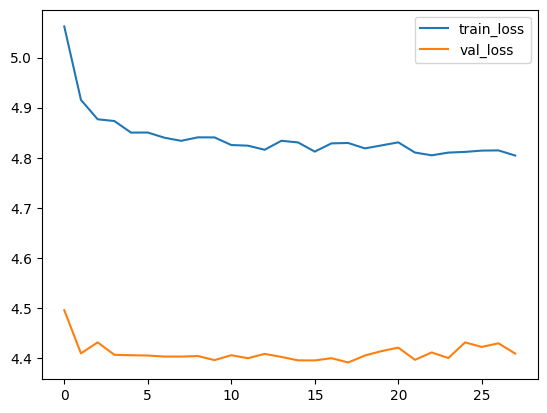

In [38]:
_ = log.plot()

We can get the partial log-likelihood

In [39]:
model.partial_log_likelihood(*val).mean()

-5.185586

## Prediction

For evaluation we first need to obtain survival estimates for the test set.
This can be done with `model.predict_surv` which returns an array of survival estimates, or with `model.predict_surv_df` which returns the survival estimates as a dataframe.

However, as `CoxPH` is semi-parametric, we first need to get the non-parametric baseline hazard estimates with `compute_baseline_hazards`. 

Note that for large datasets the `sample` argument can be used to estimate the baseline hazard on a subset.

In [40]:
_ = model.compute_baseline_hazards()

In [41]:
surv = model.predict_surv_df(x_test)

In [42]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

We can use the `EvalSurv` class for evaluation the concordance, brier score and binomial log-likelihood. Setting `censor_surv='km'` means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [43]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [44]:
ev.concordance_td()

0.6861483841356408

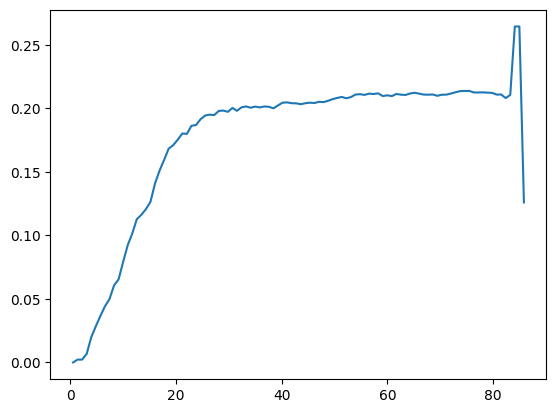

In [45]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [46]:
ev.integrated_brier_score(time_grid)

0.17807672705743344

In [47]:
ev.integrated_nbll(time_grid)

0.5257736111151908